# DistClassiPy Demo

**Author**: Sid Chaini, October 22, 2024

This notebook gives a quick demo of using DistClassiPy to classify light curve features. For this demo, I will use the data from the Zwicky Transient Facility Source Classification Project (SCoPe) [(Healy et al. 2024)](https://arxiv.org/abs/2312.00143). 

<!-- [![github-badge](https://img.shields.io/badge/GitHub-sidchaini/DistClassiPyTutorial-blue)](https://github.com/sidchaini/DistClassiPyTutorial) -->
[![colab-button](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sidchaini/DistClassiPyTutorial/blob/main/tutorial.ipynb)


### 0. Prerequisites

In [1]:
!pip install distclassipy==0.2.1 # latest as of 2024-10-22

In [2]:
%%capture
!wget https://github.com/sidchaini/DistClassiPyTutorial/archive/refs/heads/main.zip
!unzip main.zip
!mv DistClassiPyTutorial-main/* .
!rm -rf main.zip DistClassiPyTutorial-main

In [3]:
import numpy as np
seed = 0
np.random.seed(seed)
import pandas as pd
import distclassipy as dcpy
import utils
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

In [4]:
assert dcpy.__version__=="0.2.1"

### 1. Visualizing 2D distance metric spaces

We can visualize the distance metric space by plotting the locus of a central point, such as (5, 5) in a given two dimensional space. The locus appear as contour lines, which can illustrate geometry of the space when plotted in Euclidean space.

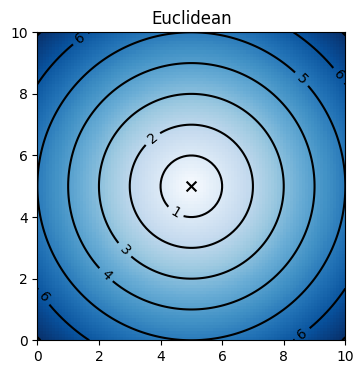

In [5]:
utils.visualize_distance("euclidean")
plt.show()

### 2. Data

For this example, we will be using data from "The ZTF Source Classification Project: III. A Catalog of Variable Sources" through which they have made available on Zenodo.

[![zenodo-badge](https://zenodo.org/badge/DOI/10.5281/zenodo.13920513.svg)](https://zenodo.org/records/13920513)

I downloaded and sampled them to choose 4000 objects from 4 classes of variable stars:

In [6]:
features = pd.read_csv("data/ztfscope_features.csv", index_col=0)
labels = pd.read_csv("data/ztfscope_labels.csv", index_col=0)
labels.value_counts()

class
CEP      1000
DSCT     1000
RR       1000
RRc      1000
Name: count, dtype: int64

In the  understand what's going on, let us focus on three simple features (refer to [(Healy et al. 2024)](https://arxiv.org/abs/2312.00143) for more details):
- ```inv_vonneumannratio```: Inverse of von Neumann ratio ([von Neumann 1941](https://projecteuclid.org/journals/annals-of-mathematical-statistics/volume-12/issue-4/Distribution-of-the-Ratio-of-the-Mean-Square-Successive-Difference/10.1214/aoms/1177731677.full), [1942](https://projecteuclid.org/journals/annals-of-mathematical-statistics/volume-13/issue-1/A-Further-Remark-Concerning-the-Distribution-of-the-Ratio-of/10.1214/aoms/1177731645.full)), which is the ratio of correlated variance and variance: a sign of variablity.
- ```norm_peak_to_peak_amp```: Normalized peak-to-peak amplitude (Sokolovsky et al. 2009)
- ```stetson_k```: Stetson K coefficient ([Stetson 1996](https://iopscience.iop.org/article/10.1086/133808/meta?casa_token=EMo0hxKqIkUAAAAA:b8y8ONGzEQAJq2WJfrCASQt_FMw7HX_h7i-VChDbTYc1ShDkEih4I2Sm184VFLTS1UpDbATGN8GPmTY4YXRG87jP2Q))

In [7]:
feature_names = ['inv_vonneumannratio', 'norm_peak_to_peak_amp', 'stetson_k']

In [8]:
X = features.loc[:,feature_names].to_numpy()
y = labels.to_numpy().ravel()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=seed)

### 3. DistanceMetricClassifier

The DistanceMetricClassifier calculates the distance between a centroid for each class, and each test point, and scales it by the standard deviation.

In [10]:
clf = dcpy.DistanceMetricClassifier()
clf.fit(X_train, y_train)

DistanceMetricClassifier()

In [11]:
y_pred = clf.predict(X_test, metric="euclidean")
acc = accuracy_score(y_true = y_test, y_pred = y_pred)
f1 = f1_score(y_true = y_test, y_pred = y_pred, average="macro")

print(f"Accuracy = {acc:.3f}")
print(f"F1 = {f1:.3f}")

Accuracy = 0.642
F1 = 0.635


In [12]:
quantile_scores_df, best_metrics_per_quantile, group_bins = dcpy.classifier.find_best_metrics(clf, X_train, y_train, feat_idx=0, n_quantiles=6, random_state=seed)

In [13]:
# quantile_scores_df

### 4. EnsembleDistanceClassifier

The EnsembleDistanceClassifier splits the training set into multiple quantiles based on a feature (```feat_idx```), iterates among all metrics to see which one performs the best on a validation set, and then prepares an ensemble based on the best performing metric for each quantile.

In [14]:
ensemble_clf = dcpy.EnsembleDistanceClassifier(feat_idx=0, random_state=seed)
ensemble_clf.fit(X_train, y_train,n_quantiles=6)

EnsembleDistanceClassifier(feat_idx=0, random_state=0)

In [15]:
y_pred_ensemble = ensemble_clf.predict(X_test)
acc = accuracy_score(y_true = y_test, y_pred = y_pred_ensemble)
f1 = f1_score(y_true = y_test, y_pred = y_pred_ensemble, average="macro")

print(f"Accuracy = {acc:.3f}")
print(f"F1 = {f1:.3f}")

Accuracy = 0.783
F1 = 0.783


In [16]:
ensemble_clf.best_metrics_per_quantile_

Quantile 1               taneja
Quantile 2         kumarjohnson
Quantile 3            hellinger
Quantile 4             canberra
Quantile 5    vicis_wave_hedges
Quantile 6            euclidean
dtype: object

In [17]:
ensemble_clf.quantile_scores_df_.drop_duplicates()

,Quantile 1,Quantile 2,Quantile 3,Quantile 4,Quantile 5,Quantile 6
euclidean,60.8,59.2,56.0,53.6,43.2,90.4
braycurtis,53.6,59.2,72.8,60.0,50.4,90.4
canberra,91.2,72.8,80.0,68.0,59.2,90.4
cityblock,63.2,58.4,56.0,55.2,43.2,90.4
chebyshev,62.4,60.8,57.6,53.6,44.0,90.4
clark,91.2,68.0,77.6,67.2,57.6,90.4
correlation,30.4,20.8,53.6,48.8,44.0,83.2
cosine,48.8,43.2,69.6,52.0,43.2,90.4
hellinger,88.0,68.0,85.6,67.2,49.6,90.4
jaccard,52.8,64.8,70.4,58.4,49.6,90.4
